<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_photodiode_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test photodiode model

In [1]:
if 'google.colab' in str(get_ipython()):
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Processing /content/OptiCommPy
  Preparing metadata (setup.py) ... done
  Created wheel for OptiCommPy: filename=OptiCommPy-0.9.0-py3-none-any.whl size=81662 sha256=ef0453ad921b75ce8627b9dd4fc8455ce0e2e6209e112882ec1bdc392c2cf292
  Stored in directory: /tmp/pip-ephem-wheel-cache-02528zok/wheels/0a/b3/b4/c1f785c2fbf2de32a986f34e6d5146d854df27f3012a7f465d
Successfully built OptiCommPy
  Attempting uninstall: OptiCommPy
    Found existing installation: OptiCommPy 0.9.0
    Uninstalling OptiCommPy-0.9.0:
      Successfully uninstalled OptiCommPy-0.9.0


In [2]:
import numpy as np
from optic.models.devices import mzm, photodiode, voa
from optic.comm.modulation import modulateGray
from optic.comm.metrics import bert
from optic.dsp.core import upsample, pulseShape, signal_power, pnorm

try:
    from optic.dsp.coreGPU import checkGPU
    if checkGPU():
        from optic.dsp.coreGPU import firFilter
    else:
        from optic.dsp.core import firFilter
except ImportError:
    from optic.dsp.core import firFilter

from optic.utils import parameters, dBm2W
from optic.plot import eyediagram
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import scipy as sp

In [3]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [4]:
# plotting options
figsize(6, 3)

In [5]:
np.random.seed(seed=123) # fixing the seed to get reproducible results

### Intensity modulation with direct-detection (IM/DD)  and On-Off Keying (OOK)

In [15]:
# simulation parameters
SpS = 8     # samples per symbol
M = 2        # order of the modulation format
Rs = 50e9    # Symbol rate/Bit rate
Fs = Rs*SpS  # Sampling frequency
Ts = 1/Fs    # Sampling period

# Laser power
Pi_dBm = 10        # laser optical power at the input of the MZM in dBm
Pi = dBm2W(Pi_dBm) # convert from dBm to W

# MZM parameters
paramMZM = parameters()
paramMZM.Vpi = 2
paramMZM.Vb = -paramMZM.Vpi/2

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=1000000)

# generate 2-PAM modulated symbol sequence
symbTx = modulateGray(bitsTx, M, 'pam')
symbTx = pnorm(symbTx) # power normalization

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)

# pulse shaping
sigTx = firFilter(pulse, symbolsUp)
sigTx /=np.max(np.abs(sigTx))

# optical modulation
Ai = np.sqrt(Pi)
sigTxo = mzm(Ai, sigTx, paramMZM)

print('Average power of the modulated optical signal [dBm]: %.2f dBm'%(10*np.log10(signal_power(sigTxo)/1e-3)))

Average power of the modulated optical signal [dBm]: 6.99 dBm


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

<ipython-input-17-9b669ae72f51>:38: RuntimeWarning: invalid value encountered in log10
  plt.plot(Prx, 10*np.log10(Q),'-o', label=title)


  0%|          | 0/40 [00:00<?, ?it/s]

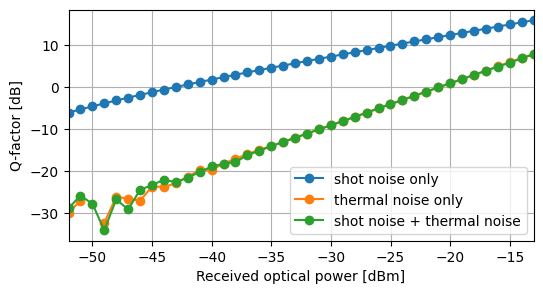

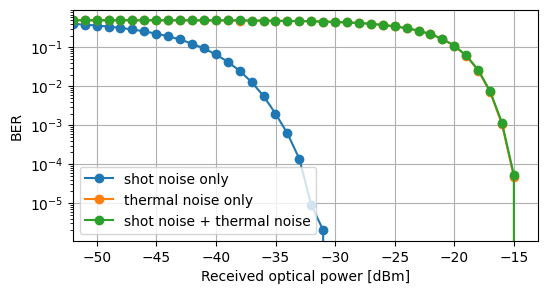

In [17]:
# photodiode parameters
paramPD = parameters()
paramPD.shotNoise = True
paramPD.thermalNoise = False
paramPD.bandwidthLimitation = False
paramPD.B = 4*Rs
paramPD.Fs = Fs

attenuation = np.arange(20, 60)
BER = np.zeros(attenuation.shape)
Q = np.zeros(attenuation.shape)

for cases in range(3):
    if cases == 0:
        title = 'shot noise only'
        paramPD.shotNoise = True
        paramPD.thermalNoise = False
    elif cases == 1:
        title = 'thermal noise only'
        paramPD.shotNoise = False
        paramPD.thermalNoise = True
    else:
        title = 'shot noise + thermal noise'
        paramPD.shotNoise = True
        paramPD.thermalNoise = True

    for ind, att in enumerate(tqdm(attenuation)):
        sigAtt = voa(sigTxo, att)
        I_Rx = photodiode(sigAtt, paramPD)
        I_Rx = I_Rx/np.std(I_Rx)
        I_Rx = I_Rx[0::SpS]
        BER[ind], Q[ind] = bert(I_Rx, bitsTx)


    Ptx = 10*np.log10(signal_power(sigTxo)/1e-3)
    Prx = Ptx-attenuation
    plt.figure(1)
    plt.plot(Prx, 10*np.log10(Q),'-o', label=title)
    plt.xlabel('Received optical power [dBm]')
    plt.ylabel('Q-factor [dB]')
    plt.grid()
    plt.legend()
    plt.xlim(min(Prx), max(Prx));

    plt.figure(2)
    plt.semilogy(Prx, BER,'-o', label=title)
    plt.xlabel('Received optical power [dBm]')
    plt.ylabel('BER')
    plt.grid()
    plt.legend()
    plt.xlim(min(Prx), max(Prx));